In [1]:
import matplotlib.pyplot as plt
import random
import requests
import json
from tqdm import tqdm
import numpy as np
import os
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.colors as colors
import seaborn as sns
from collections import defaultdict

In [2]:
# Load Dataset
with open(f'updated_dataset.json', 'r', encoding='utf-8-sig') as file:
    dataset = json.load(file)

In [3]:
def remove_outliers(data, threshold=1.5):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return (data >= lower_bound) & (data <= upper_bound)

In [4]:
lines_changed = [pr['linesChanged'] for pr in dataset]
files_changed = [pr['filesChanged'] for pr in dataset]
lines_added = [pr['linesAdded'] for pr in dataset]
lines_removed = [pr['linesRemoved'] for pr in dataset]

In [5]:
# Remove Outliers
valid_lines = remove_outliers(lines_changed, 10)
valid_files = remove_outliers(files_changed, 10)

valid_additions = remove_outliers(lines_added, 10)
valid_deletions = remove_outliers(lines_removed, 10)

filtered_dataset = [
    pr for i, pr in enumerate(dataset) if valid_lines[i] and valid_files[i] and valid_additions[i] and valid_deletions[i]
]

In [6]:
lines_changed = [pr['linesChanged'] for pr in filtered_dataset]
files_changed = [pr['filesChanged'] for pr in filtered_dataset]
lines_added = [pr['linesAdded'] for pr in filtered_dataset]
lines_removed = [pr['linesRemoved'] for pr in filtered_dataset]
sstub_types = [pr['sstubs'][0]['bugType'] if pr['sstubs'] else 'None' for pr in filtered_dataset]

# Separate 'None' and SStuB points
none_indices = [i for i, t in enumerate(sstub_types) if t == 'None']
sstub_indices = [i for i, t in enumerate(sstub_types) if t != 'None']

# Get coordinates for None and SStuBs
lines_none = [lines_changed[i] for i in none_indices]
files_none = [files_changed[i] for i in none_indices]
add_none = [lines_added[i] for i in none_indices]
remove_none = [lines_removed[i] for i in none_indices]
    
lines_sstub = [lines_changed[i] for i in sstub_indices]
files_sstub = [files_changed[i] for i in sstub_indices]
add_sstub = [lines_added[i] for i in sstub_indices]
remove_sstub = [lines_removed[i] for i in sstub_indices]

# Assign colors to SStuBs
sstub_unique_types = sorted(set([sstub_types[i] for i in sstub_indices]))
prominent_colors = plt.cm.get_cmap('tab20', 16)

# Map colors for SStuBs
sstub_color_map = {stype: prominent_colors(i) for i, stype in enumerate(sstub_unique_types)}
sstub_colors = [sstub_color_map[sstub_types[i]] for i in sstub_indices]

C:\Users\miles\AppData\Local\Temp\ipykernel_21984\3632434697.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  prominent_colors = plt.cm.get_cmap('tab20', 16)


C:\Users\miles\AppData\Local\Temp\ipykernel_29480\1985144041.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=data["lines_changed"], y=data["files_changed"], cmap="Reds", fill=True, ax=ax1)
C:\Users\miles\AppData\Local\Temp\ipykernel_29480\1985144041.py:35: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=data["lines_added"], y=data["lines_removed"], cmap="Blues", fill=True, ax=ax2)
C:\Users\miles\AppData\Local\Temp\ipykernel_29480\1985144041.py:35: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=data["lines_added"], y=data["lines_removed"], cmap="Blues", fill=True, ax=ax2)
C:\Users\miles\AppData\Local\Temp\ipykernel_29480\1985144041.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covaria

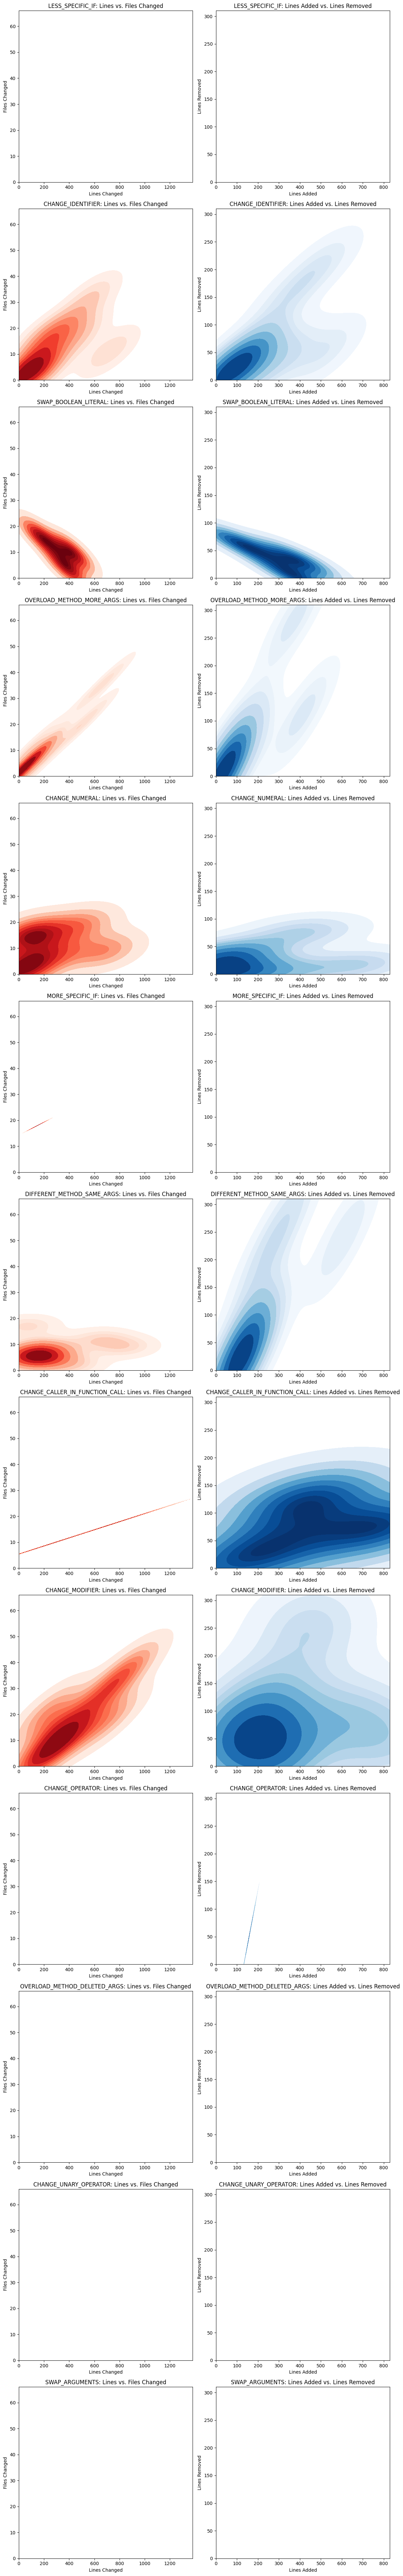

In [7]:
sstub_data = defaultdict(lambda: {"lines_changed": [], "files_changed": [], "lines_added": [], "lines_removed": []})
for i, bug_type in enumerate(sstub_types):
    if bug_type != "None":
        sstub_data[bug_type]["lines_changed"].append(lines_changed[i])
        sstub_data[bug_type]["files_changed"].append(files_changed[i])
        sstub_data[bug_type]["lines_added"].append(lines_added[i])
        sstub_data[bug_type]["lines_removed"].append(lines_removed[i])

all_lines_changed = np.concatenate([data["lines_changed"] for data in sstub_data.values()])  # CHANGED
all_files_changed = np.concatenate([data["files_changed"] for data in sstub_data.values()])  # CHANGED
all_lines_added = np.concatenate([data["lines_added"] for data in sstub_data.values()])      # CHANGED
all_lines_removed = np.concatenate([data["lines_removed"] for data in sstub_data.values()])  # CHANGED

xlim_lines_files = (0, max(lines_changed)+10)                          # CHANGED
ylim_lines_files = (0, max(files_changed)+10)                          # CHANGED
xlim_lines_added_removed = (0, max(all_lines_added))                      # CHANGED
ylim_lines_added_removed = (0, max(all_lines_removed))                  # CHANGED

# Set up plots
num_bug_types = len(sstub_data)
fig, axes = plt.subplots(num_bug_types, 2, figsize=(12, 6 * num_bug_types))

for idx, (bug_type, data) in enumerate(sstub_data.items()):
    ax1, ax2 = axes[idx] if num_bug_types > 1 else (axes[0], axes[1])  # Handle single bug type case

    # Heatmap: Lines Changed vs. Files Changed
    sns.kdeplot(x=data["lines_changed"], y=data["files_changed"], cmap="Reds", fill=True, ax=ax1)
    ax1.set_title(f"{bug_type}: Lines vs. Files Changed")
    ax1.set_xlabel("Lines Changed")
    ax1.set_ylabel("Files Changed")
    ax1.set_xlim(xlim_lines_files)        # CHANGED
    ax1.set_ylim(ylim_lines_files)        # CHANGED

    # Heatmap: Lines Added vs. Lines Removed
    sns.kdeplot(x=data["lines_added"], y=data["lines_removed"], cmap="Blues", fill=True, ax=ax2)
    ax2.set_title(f"{bug_type}: Lines Added vs. Lines Removed")
    ax2.set_xlabel("Lines Added")
    ax2.set_ylabel("Lines Removed")
    ax2.set_xlim(xlim_lines_added_removed)  # CHANGED
    ax2.set_ylim(ylim_lines_added_removed)  # CHANGED

plt.tight_layout()
plt.show()

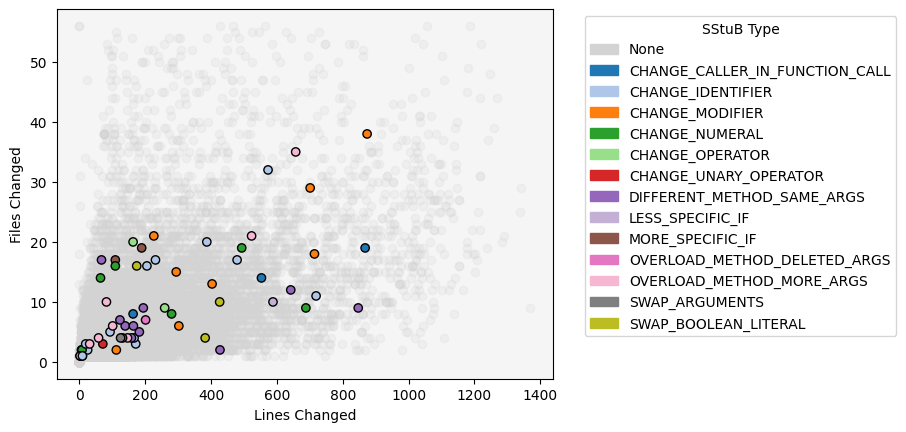

In [7]:
# Plot
fig, ax = plt.subplots()
ax.set_facecolor('whitesmoke')

# Plot None points (light gray, alpha 0.4)
ax.scatter(lines_none, files_none, c='lightgray', alpha=0.2, label='None')

# Plot SStuBs (vibrant colors, alpha 0.8)
sc = ax.scatter(lines_sstub, files_sstub, c=sstub_colors, alpha=1.0, edgecolors='black')

# Create legend
legend_handles = [Patch(color='lightgray', label='None')] + \
                 [Patch(color=sstub_color_map[stype], label=stype) for stype in sstub_unique_types]

plt.legend(handles=legend_handles, title='SStuB Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Labels
plt.xlabel('Lines Changed')
plt.ylabel('Files Changed')
plt.show()

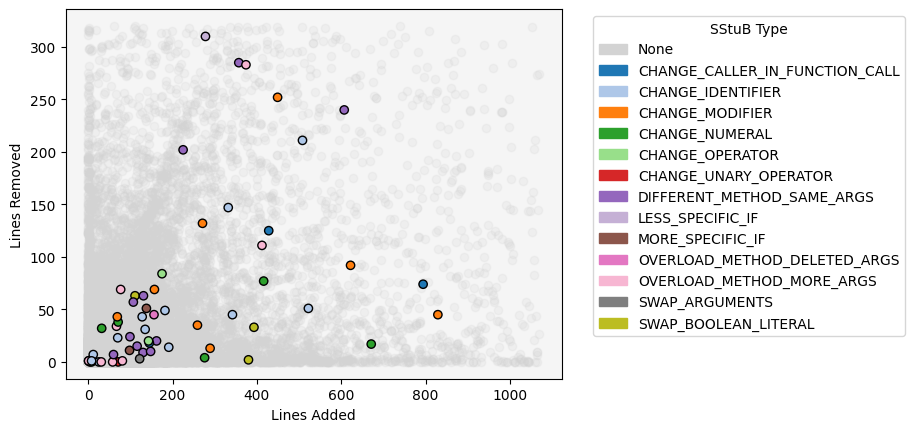

In [8]:
# Plot
fig, ax = plt.subplots()
ax.set_facecolor('whitesmoke')

# Plot None points (light gray, alpha 0.4)
ax.scatter(add_none, remove_none, c='lightgray', alpha=0.2, label='None')

# Plot SStuBs (vibrant colors, alpha 0.8)
sc = ax.scatter(add_sstub, remove_sstub, c=sstub_colors, alpha=1.0, edgecolors='black')

# Create legend
legend_handles = [Patch(color='lightgray', label='None')] + \
                 [Patch(color=sstub_color_map[stype], label=stype) for stype in sstub_unique_types]

plt.legend(handles=legend_handles, title='SStuB Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Labels
plt.xlabel('Lines Added')
plt.ylabel('Lines Removed')
plt.show()

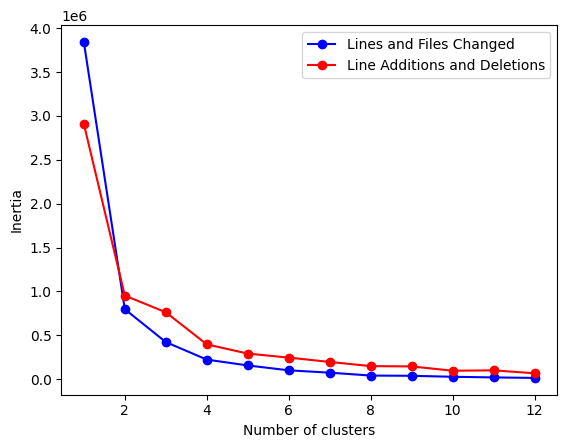

In [10]:
lf_data = list(zip(lines_sstub, files_sstub))
ar_data = list(zip(add_sstub, remove_sstub))

lf_inertias = []
ar_inertias = []

for i in range(1,13):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(lf_data)
    lf_inertias.append(kmeans.inertia_)

for i in range(1,13):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ar_data)
    ar_inertias.append(kmeans.inertia_)


plt.plot(range(1,13), lf_inertias, marker='o', color='blue', label="Lines and Files Changed")
plt.plot(range(1,13), ar_inertias, marker='o', color='red', label="Line Additions and Deletions")
plt.title('Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

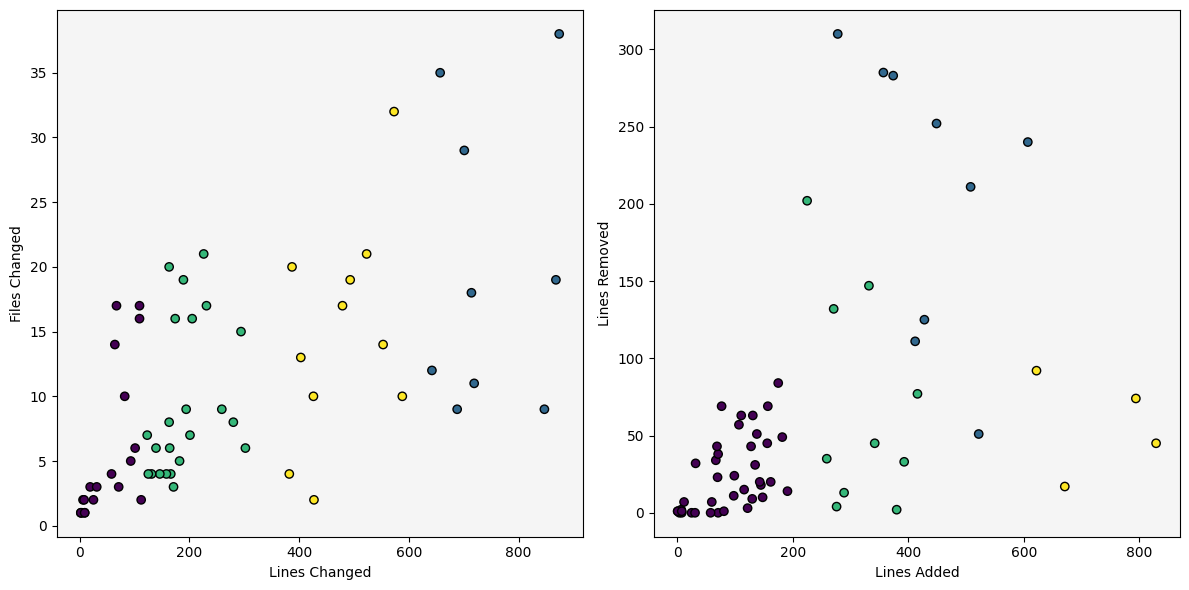

In [11]:
lf_kmeans = KMeans(n_clusters=4)
lf_kmeans.fit(lf_data)

ar_kmeans = KMeans(n_clusters=4)
ar_kmeans.fit(ar_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_facecolor('whitesmoke')
ax1.scatter(lines_sstub, files_sstub, c=lf_kmeans.labels_, edgecolors='black')
ax1.set_xlabel('Lines Changed')
ax1.set_ylabel('Files Changed')


ax2.set_facecolor('whitesmoke')
ax2.scatter(add_sstub, remove_sstub, c=ar_kmeans.labels_, edgecolors='black')
ax2.set_xlabel('Lines Added')
ax2.set_ylabel('Lines Removed')

plt.tight_layout()
plt.show()

In [ ]:
lines_none = 

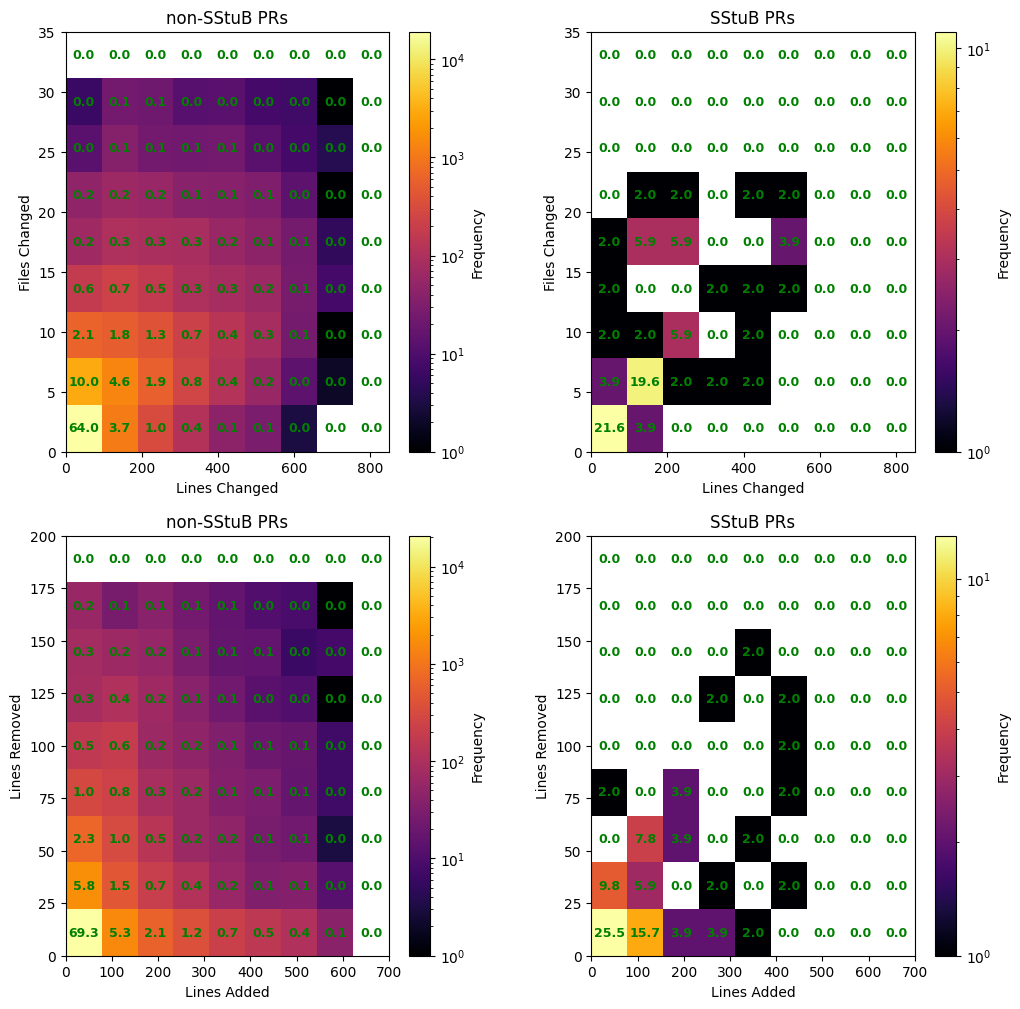

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

x_bins = np.linspace(0, 850, 10)  # Bins from 0 to 600 in steps of 50
y_bins = np.linspace(0, 35, 10)

heatmap, xedges, yedges = np.histogram2d(lines_none, files_none, bins=[x_bins, y_bins])

total = np.sum(heatmap)
heatmap_percent = (heatmap / total) * 100  # Convert each count to a percentage

# Avoid log(0) by replacing zero values with a small number
heatmap_percent[heatmap_percent == 0] = 0.01

X, Y = np.meshgrid(xedges, yedges)
c = axs[0, 0].pcolormesh(X, Y, heatmap.T, cmap='inferno', shading='auto', norm=colors.LogNorm())
cb = fig.colorbar(c, ax=axs[0, 0])
cb.set_label('Frequency')

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = heatmap_percent[i, j]
        if value > 0:  # Only label non-zero blocks
            x_text = (xedges[i] + xedges[i + 1]) / 2  # X center
            y_text = (yedges[j] + yedges[j + 1]) / 2  # Y center
            axs[0,0].text(x_text, y_text, f"{value:.1f}", ha='center', va='center', 
                                  color='green', fontsize=9, fontweight='bold')

axs[0,0].set_xlabel('Lines Changed')
axs[0,0].set_ylabel('Files Changed')

heatmap, xedges, yedges = np.histogram2d(lines_sstub, files_sstub, bins=[x_bins, y_bins])

total = np.sum(heatmap)
heatmap_percent = (heatmap / total) * 100  # Convert each count to a percentage

# Avoid log(0) by replacing zero values with a small number
heatmap_percent[heatmap_percent == 0] = 0.01

X, Y = np.meshgrid(xedges, yedges)
c = axs[0, 1].pcolormesh(X, Y, heatmap.T, cmap='inferno', shading='auto', norm=colors.LogNorm())
cb = fig.colorbar(c, ax=axs[0, 1])
cb.set_label('Frequency')

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = heatmap_percent[i, j]
        if value > 0:  # Only label non-zero blocks
            x_text = (xedges[i] + xedges[i + 1]) / 2  # X center
            y_text = (yedges[j] + yedges[j + 1]) / 2  # Y center
            axs[0, 1].text(x_text, y_text, f"{value:.1f}", ha='center', va='center', 
                                  color='green', fontsize=9, fontweight='bold')

axs[0,1].set_xlabel('Lines Changed')
axs[0,1].set_ylabel('Files Changed')

x_bins = np.linspace(0, 700, 10)  # Bins from 0 to 600 in steps of 50
y_bins = np.linspace(0, 200, 10)
heatmap, xedges, yedges = np.histogram2d(add_none, remove_none, bins=[x_bins, y_bins])

total = np.sum(heatmap)
heatmap_percent = (heatmap / total) * 100  # Convert each count to a percentage

# Avoid log(0) by replacing zero values with a small number
heatmap_percent[heatmap_percent == 0] = 0.01

X, Y = np.meshgrid(xedges, yedges)
c = axs[1, 0].pcolormesh(X, Y, heatmap.T, cmap='inferno', shading='auto', norm=colors.LogNorm())
cb = fig.colorbar(c, ax=axs[1, 0])
cb.set_label('Frequency')

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = heatmap_percent[i, j]
        if value > 0:  # Only label non-zero blocks
            x_text = (xedges[i] + xedges[i + 1]) / 2  # X center
            y_text = (yedges[j] + yedges[j + 1]) / 2  # Y center
            axs[1, 0].text(x_text, y_text, f"{value:.1f}", ha='center', va='center', 
                                  color='green', fontsize=9, fontweight='bold')

axs[1,0].set_xlabel('Lines Added')
axs[1,0].set_ylabel('Lines Removed')

heatmap, xedges, yedges = np.histogram2d(add_sstub, remove_sstub, bins=[x_bins, y_bins])

total = np.sum(heatmap)
heatmap_percent = (heatmap / total) * 100  # Convert each count to a percentage

# Avoid log(0) by replacing zero values with a small number
heatmap_percent[heatmap_percent == 0] = 0.01

X, Y = np.meshgrid(xedges, yedges)
c = axs[1, 1].pcolormesh(X, Y, heatmap.T, cmap='inferno', shading='auto', norm=colors.LogNorm())
cb = fig.colorbar(c, ax=axs[1, 1])
cb.set_label('Frequency')

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = heatmap_percent[i, j]
        if value > 0:  # Only label non-zero blocks
            x_text = (xedges[i] + xedges[i + 1]) / 2  # X center
            y_text = (yedges[j] + yedges[j + 1]) / 2  # Y center
            axs[1, 1].text(x_text, y_text, f"{value:.1f}", ha='center', va='center', 
                                  color='green', fontsize=9, fontweight='bold')
            
axs[1,1].set_xlabel('Lines Added')
axs[1,1].set_ylabel('Lines Removed')

axs[0,0].set_title("non-SStuB PRs")
axs[0,1].set_title("SStuB PRs")
axs[1,0].set_title("non-SStuB PRs")
axs[1,1].set_title("SStuB PRs")


plt.show()